# 1.2. Linear and Quadratic Discriminant Analysis
  
>`sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0, store_covariance=False, tol=0.0001, store_covariances=None)`  
  
Linear Discriminant Analysis (`discriminant_analysis.LinearDiscriminantAnalysis`) and Quadratic Discriminant Analysis (`discriminant_analysis.QuadraticDiscriminantAnalysis`) are two classic classifiers, with, as their names suggest, a linear and a quadratic decision surface, respectively.

**These classifiers are attractive because they have closed-form solutions that can be easily computed, are inherently multiclass, have proven to work well in practice and have no hyperparameters to tune.**   

### Linear and Quadratic Discriminant Analysis with covariance ellipsoid  
  
This example plots the covariance ellipsoids of each class and decision boundary learned by LDA and QDA. The ellipsoids display the double standard deviation for each class. With LDA, the standard deviation is the same for all the classes, while each class has its own standard deviation with QDA. 

Automatically created module for IPython interactive environment


/home/tk/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:664: DeprecationWarning: 'store_covariances' was renamed to store_covariance in version 0.19 and will be removed in 0.21.
  DeprecationWarning)
/home/tk/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function covariances_ is deprecated; Attribute covariances_ was deprecated in version 0.19 and will be removed in 0.21. Use covariance_ instead
  warnings.warn(msg, category=DeprecationWarning)
/home/tk/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function covariances_ is deprecated; Attribute covariances_ was deprecated in version 0.19 and will be removed in 0.21. Use covariance_ instead
  warnings.warn(msg, category=DeprecationWarning)
/home/tk/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:664: DeprecationWarning: 'store_covariances' was renamed to store_covariance in version 0.19 and will be rem

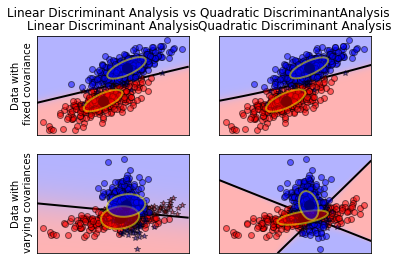

In [1]:
%matplotlib inline
print(__doc__)

from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# #############################################################################
# Colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)


# #############################################################################
# Generate datasets
def dataset_fixed_cov():
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -0.23], [0.83, .23]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


def dataset_cov():
    '''Generate 2 Gaussians samples with different covariance matrices'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -1.], [2.5, .7]]) * 2.
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


# #############################################################################
# Plot functions
def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title('Linear Discriminant Analysis')
        plt.ylabel('Data with\n fixed covariance')
    elif fig_index == 2:
        plt.title('Quadratic Discriminant Analysis')
    elif fig_index == 3:
        plt.ylabel('Data with\n varying covariances')

    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    alpha = 0.5

    # class 0: dots
    plt.plot(X0_tp[:, 0], X0_tp[:, 1], 'o', alpha=alpha,
             color='red', markeredgecolor='k')
    plt.plot(X0_fp[:, 0], X0_fp[:, 1], '*', alpha=alpha,
             color='#990000', markeredgecolor='k')  # dark red

    # class 1: dots
    plt.plot(X1_tp[:, 0], X1_tp[:, 1], 'o', alpha=alpha,
             color='blue', markeredgecolor='k')
    plt.plot(X1_fp[:, 0], X1_fp[:, 1], '*', alpha=alpha,
             color='#000099', markeredgecolor='k')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.))
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='k')

    # means
    plt.plot(lda.means_[0][0], lda.means_[0][1],
             'o', color='black', markersize=10, markeredgecolor='k')
    plt.plot(lda.means_[1][0], lda.means_[1][1],
             'o', color='black', markersize=10, markeredgecolor='k')

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='yellow',
                              linewidth=2, zorder=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariances_[0], 'red')
    plot_ellipse(splot, qda.means_[1], qda.covariances_[1], 'blue')

for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)
    plot_lda_cov(lda, splot)
    plt.axis('tight')

    # Quadratic Discriminant Analysis
    qda = QuadraticDiscriminantAnalysis(store_covariances=True)
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2)
    plot_qda_cov(qda, splot)
    plt.axis('tight')
plt.suptitle('Linear Discriminant Analysis vs Quadratic Discriminant'
             'Analysis')
plt.show()

The plot shows decision boundaries for Linear Discriminant Analysis and Quadratic Discriminant Analysis. The bottom row demonstrates that Linear Discriminant Analysis can only learn linear boundaries, while Quadratic Discriminant Analysis can learn quadratic boundaries and is therefore more flexible.

## 1.2.1. Dimensionality reduction using Linear Discriminant Analysis  
  
>`sklearn.discriminant_analysis.LinearDiscriminantAnalysis(solver=’svd’, shrinkage=None, priors=None, n_components=None, store_covariance=False, tol=0.0001)`  
  
`discriminant_analysis.LinearDiscriminantAnalysis` **can be used to perform supervised dimensionality reduction**, by projecting the input data to a linear subspace consisting of the directions which maximize the separation between classes (in a precise sense discussed in the mathematics section below). **The dimension of the output is necessarily less than the number of classes, so this is a in general a rather strong dimensionality reduction, and only makes senses in a multiclass setting.**  
  
This is implemented in `discriminant_analysis.LinearDiscriminantAnalysis.transform`. The desired dimensionality can be set using the n_components constructor parameter. This parameter has no influence on `discriminant_analysis.LinearDiscriminantAnalysis.fit` or `discriminant_analysis.LinearDiscriminantAnalysis.predict`.  
  

### Comparison of LDA and PCA 2D projection of Iris dataset
  
The Iris dataset represents 3 kind of Iris flowers (Setosa, Versicolour and Virginica) with 4 attributes: sepal length, sepal width, petal length and petal width.  
  
Principal Component Analysis (PCA) applied to this data identifies the combination of attributes (principal components, or directions in the feature space) that account for the most variance in the data. Here we plot the different samples on the 2 first principal components.  
  
Linear Discriminant Analysis (LDA) tries to identify attributes that account for the most variance between classes. In particular, LDA, in contrast to PCA, is a supervised method, using known class labels.  

Automatically created module for IPython interactive environment
explained variance ratio (first two components): [0.92461621 0.05301557]


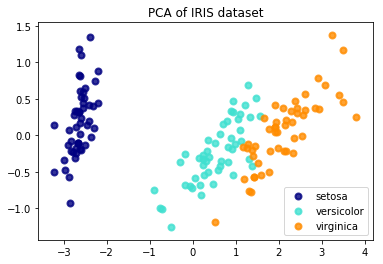

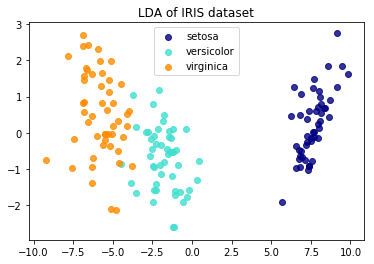

In [2]:
%matplotlib inline
print(__doc__)

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()


## 1.2.2. Mathematical formulation of the LDA and QDA classifiers 
  
Both LDA and QDA can be derived from simple probabilistic models which model the class conditional distribution of the data $P(X|y=k)$ for each class $k$. Predictions can then be obtained by using Bayes’ rule:  
  
$P(y=k | X) = \frac{P(X | y=k) P(y=k)}{P(X)} = \frac{P(X | y=k) P(y = k)}{ \sum_{l} P(X | y=l) \cdot P(y=l)}$  
  
and we select the class k which maximizes this conditional probability.  
  
More specifically, for linear and quadratic discriminant analysis, $P(X|y)$ is modelled as a multivariate Gaussian distribution with density:  
  
$p(X | y=k) = \frac{1}{(2\pi)^n |\Sigma_k|^{1/2}}\exp\left(-\frac{1}{2} (X-\mu_k)^t \Sigma_k^{-1} (X-\mu_k)\right)$  
  
To use this model as a classifier, we just need to estimate from the training data the class priors $P(y=k)$ (by the proportion of instances of class $k$), the class means $\mu_k$ (by the empirical sample class means) and the covariance matrices (either by the empirical sample class covariance matrices, or by a regularized estimator: see the section on shrinkage below).  
  
In the case of LDA, the Gaussians for each class are assumed to share the same covariance matrix: $\Sigma_k = \Sigma$ for all $k$. This leads to linear decision surfaces between, as can be seen by comparing the log-probability ratios $\log[P(y=k | X) / P(y=l | X)]$:  
  
$\log\left(\frac{P(y=k|X)}{P(y=l | X)}\right) = 0 \Leftrightarrow (\mu_k-\mu_l)\Sigma^{-1} X = \frac{1}{2} (\mu_k^t \Sigma^{-1} \mu_k - \mu_l^t \Sigma^{-1} \mu_l)$
  
In the case of QDA, there are no assumptions on the covariance matrices $\Sigma_k$ of the Gaussians, leading to quadratic decision surfaces. 

### Note: Relation with Gaussian Naive Bayes

If in the QDA model one assumes that the covariance matrices are diagonal, then the inputs are assumed to be conditionally independent in each class, and the resulting classifier is equivalent to the Gaussian Naive Bayes classifier `naive_bayes.GaussianNB`.


## 1.2.3. Mathematical formulation of LDA dimensionality reduction
  
To understand the use of LDA in dimensionality reduction, it is useful to start with a geometric reformulation of the LDA classification rule explained above. We write K for the total number of target classes. Since in LDA we assume that all classes have the same estimated covariance \Sigma, we can rescale the data so that this covariance is the identity:  
  
$X^* = D^{-1/2}U^t X\text{ with }\Sigma = UDU^t$  
  
Then one can show that to classify a data point after scaling is equivalent to finding the estimated class mean $\mu^*_k$ which is closest to the data point in the Euclidean distance. But this can be done just as well after projecting on the $K-1$ affine subspace $H_K$ generated by all the $\mu^*_k$ for all classes. This shows that, implicit in the LDA classifier, there is a dimensionality reduction by linear projection onto a $K-1$ dimensional space.

We can reduce the dimension even more, to a chosen L, by projecting onto the linear subspace $H_L$ which maximize the variance of the $\mu^*_k$ after projection (in effect, we are doing a form of PCA for the transformed class means $\mu^*_k$). This L corresponds to the `n_components` parameter used in the `discriminant_analysis.LinearDiscriminantAnalysis.transform method`. 

## 1.2.4. Shrinkage
  
Shrinkage is a tool to improve estimation of covariance matrices in situations where the number of training samples is small compared to the number of features. In this scenario, the empirical sample covariance is a poor estimator. Shrinkage LDA can be used by setting the shrinkage parameter of the `discriminant_analysis.LinearDiscriminantAnalysis` class to `‘auto’`. This automatically determines the optimal shrinkage parameter in an analytic way. Note that currently shrinkage only works when setting the `solver` parameter to `‘lsqr’` or `‘eigen’`.

The shrinkage parameter can also be manually set between 0 and 1. In particular, a value of 0 corresponds to no shrinkage (which means the empirical covariance matrix will be used) and a value of 1 corresponds to complete shrinkage (which means that the diagonal matrix of variances will be used as an estimate for the covariance matrix). Setting this parameter to a value between these two extrema will estimate a shrunk version of the covariance matrix.  

## 1.2.5. Estimation algorithms
  
The default `solver` is `‘svd’`. **It can perform both classification and transform, and it does not rely on the calculation of the covariance matrix. This can be an advantage in situations where the number of features is large**. However, the `‘svd’` solver **cannot be used with shrinkage**.  
  
The `‘lsqr’` solver is **an efficient algorithm that only works for classification. It supports shrinkage.**  
  
The `‘eigen’` solver is based on the optimization of the between class scatter to within class scatter ratio. It **can be used for both classification and transform, and it supports shrinkage**. However, the `‘eigen’` solver needs to compute the covariance matrix, so **it might not be suitable for situations with a high number of features**.  

### Normal and Shrinkage Linear Discriminant Analysis for classification
  
Shows how shrinkage improves classification.

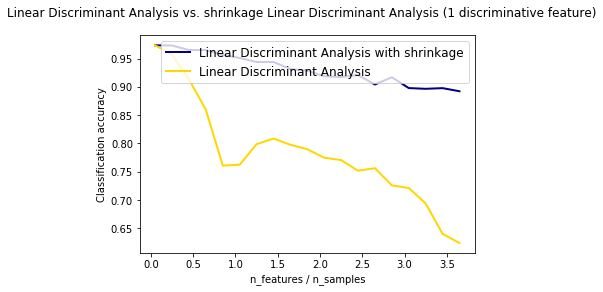

In [3]:
%matplotlib inline
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


n_train = 20  # samples for training
n_test = 200  # samples for testing
n_averages = 50  # how often to repeat classification
n_features_max = 75  # maximum number of features
step = 4  # step size for the calculation


def generate_data(n_samples, n_features):
    """Generate random blob-ish data with noisy features.

    This returns an array of input data with shape `(n_samples, n_features)`
    and an array of `n_samples` target labels.

    Only one feature contains discriminative information, the other features
    contain only noise.
    """
    X, y = make_blobs(n_samples=n_samples, n_features=1, centers=[[-2], [2]])

    # add non-discriminative features
    if n_features > 1:
        X = np.hstack([X, np.random.randn(n_samples, n_features - 1)])
    return X, y

acc_clf1, acc_clf2 = [], []
n_features_range = range(1, n_features_max + 1, step)
for n_features in n_features_range:
    score_clf1, score_clf2 = 0, 0
    for _ in range(n_averages):
        X, y = generate_data(n_train, n_features)

        clf1 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X, y)
        clf2 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=None).fit(X, y)

        X, y = generate_data(n_test, n_features)
        score_clf1 += clf1.score(X, y)
        score_clf2 += clf2.score(X, y)

    acc_clf1.append(score_clf1 / n_averages)
    acc_clf2.append(score_clf2 / n_averages)

features_samples_ratio = np.array(n_features_range) / n_train

plt.plot(features_samples_ratio, acc_clf1, linewidth=2,
         label="Linear Discriminant Analysis with shrinkage", color='navy')
plt.plot(features_samples_ratio, acc_clf2, linewidth=2,
         label="Linear Discriminant Analysis", color='gold')

plt.xlabel('n_features / n_samples')
plt.ylabel('Classification accuracy')

plt.legend(loc=1, prop={'size': 12})
plt.suptitle('Linear Discriminant Analysis vs. \
shrinkage Linear Discriminant Analysis (1 discriminative feature)')
plt.show()
